# Automatic Extraction of Fine Structural Information in ARPES by Multi-Stage Clustering Algorithm

Lingzhu Bian, Chen Liu, Zhen Zhang, Yingke Huang, Xinyu Pan, Yi Zhang, Jiaou Wang, Zhesheng Chen, Yuhui Dong  

Correspondence should be addressed to Lingzhu Bian (bianlz@ihep.ac.cn)

## iEDCs Fuzzy-c-means clustering

 ### - Module Setting

In [1]:
import warnings
import os
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import time
from sklearn.cluster import KMeans
from skfuzzy.cluster import cmeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from gap_statistic import OptimalK
import math
warnings.filterwarnings('ignore')
os.environ['OMP_NUM_THREADS'] = '8'
np.set_printoptions(threshold=np.inf)

### - Plot Setting

In [2]:
col_arr = ["gray","orange","brown","blue","purple", "violet"]
fontsize1=40
fontsize2=35
markershape="o"
markersize=25
plt.rcParams['font.family'] = 'Times New Roman'

### - Load data and initial settings

In [3]:
file = h5py.File("RealData.h5", 'r')
dataset = file['data']  
mapdata = dataset[:]  


# Size
xn = np.shape(mapdata)[0] # x-axis  
yn = np.shape(mapdata)[1] # y-axis
en = np.shape(mapdata)[2] # Energies
an = np.shape(mapdata)[3] # Angles
pn = xn * yn

# X axis
x_ini = 75
x_end = 165
xw = x_end-x_ini # Width 
dx = 1 # Step

# Y axis
y_ini = 175
y_end = 256
yw =y_end-y_ini  # Width
dy = 1.0125 # Step

# Mapping axes will be rescaled w.r.t. center of the image
k = 0
xpos = np.zeros(xn*yn)
ypos = np.zeros(xn*yn)
for i in range(xn):
    for j in range(yn):
        xpos[k] = -xw/2 + i*dx 
        ypos[k] = -yw/2 + j*dy 
        k += 1
    
# Energy/Angle axis
eng_ini = 84.9599
eng_end = 99.9160
engbins = 889

ang_ini = -20.0431     
ang_end = 6.6810
angbins = 32

eng = np.zeros(engbins)
for i in range(engbins):
    eng[i]=eng_ini+(eng_end-eng_ini)/(engbins-1)*i
ang = np.zeros(angbins)
for i in range(angbins):
    ang[i]=ang_ini+(ang_end-ang_ini)/(angbins-1)*i



print("Load File:", "RealData.h5")
print("\r")
print("---Data Size---")
print("Map Axis 1 :", xn)
print("Map Axis 2 :", yn)
print("Energy :", en)
print("Angle :", an)
print("Energy (start, end):", eng_ini, eng_end)
print("Angle (start, end):", ang_ini, ang_end)
print("eng:", eng)
print("ang:", ang)
print("\r")

Load File: RealData.h5

---Data Size---
Map Axis 1 : 91
Map Axis 2 : 81
Energy : 889
Angle : 32
Energy (start, end): 84.9599 99.916
Angle (start, end): -20.0431 6.681
eng: [84.9599     84.97674245 84.99358491 85.01042736 85.02726982 85.04411227
 85.06095473 85.07779718 85.09463964 85.11148209 85.12832455 85.145167
 85.16200946 85.17885191 85.19569437 85.21253682 85.22937928 85.24622173
 85.26306419 85.27990664 85.2967491  85.31359155 85.33043401 85.34727646
 85.36411892 85.38096137 85.39780383 85.41464628 85.43148874 85.44833119
 85.46517365 85.4820161  85.49885856 85.51570101 85.53254347 85.54938592
 85.56622838 85.58307083 85.59991329 85.61675574 85.6335982  85.65044065
 85.66728311 85.68412556 85.70096802 85.71781047 85.73465293 85.75149538
 85.76833784 85.78518029 85.80202275 85.8188652  85.83570766 85.85255011
 85.86939257 85.88623502 85.90307748 85.91991993 85.93676239 85.95360484
 85.9704473  85.98728975 86.00413221 86.02097466 86.03781712 86.05465957
 86.07150203 86.08834448 86

### - Flatten 4D map to 2D image (iEDCs) 

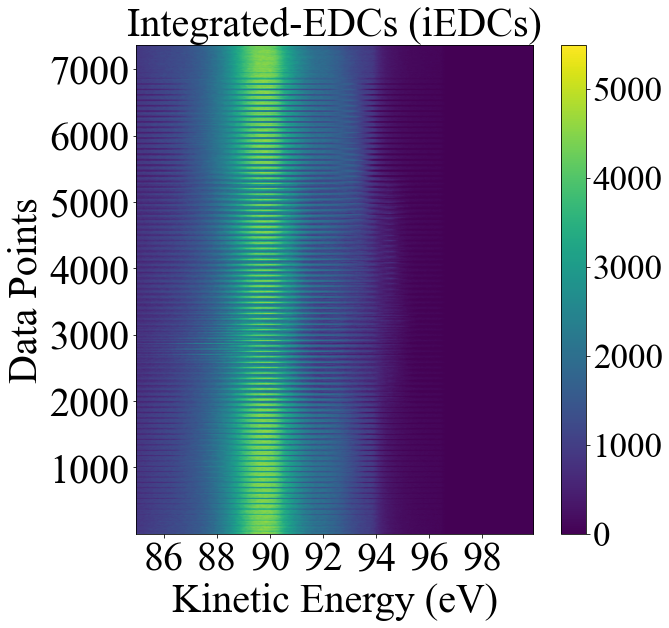

In [4]:
iEDCs = np.sum(mapdata, axis = 3).reshape(xn*yn, en) 
np.savetxt('iEDCs.txt', iEDCs)

fig = plt.figure(figsize=(10,9))
plt.rcParams['font.family'] = 'Times New Roman'
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(iEDCs, extent = [eng_ini, eng_end, 1, xn*yn], aspect = 0.0025)
cbar = fig.colorbar(im)

plt.xlabel('Kinetic Energy (eV)',fontsize=fontsize1)
plt.ylabel('Data Points',fontsize=fontsize1)
plt.title("Integrated-EDCs (iEDCs)",fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)
cbar.ax.tick_params(labelsize=fontsize2)
fig = plt.gcf()
plt.show()

### - clustering input

In [5]:
#Select iEDCs as the clustering input
targetMap = iEDCs
slice_axis = eng
sn = np.shape(eng)[0]

## Part 1: Evaluation of Fuzzy-c-means clustering    (find the optimal n and m)
### - Preset maximum number of clusters (n<sub>k</sub><sup>max</sup>) and lists of fuzzifier (m's)

In [6]:
max_nk = 10 # Maximum Cluster Number
ms = np.array([1.1, 1.3, 1.5, 1.7, 1.9, 2, 3, 4, 5])
mn = np.size(ms)
ms_index = np.linspace(0, mn-1, mn)

### - clustering

In [7]:
t1 = time.time()

fpcs = np.zeros((max_nk-1, mn))

for i in range(max_nk-1):
    for j in range(mn):
        k = i + 2 # minimum cluster number is 2
        m = ms[j]
        cntr, u, u0, d, jm, p, fpc = cmeans(targetMap.T, k, m, 0.003, 10000)  #k=2-10  m=ms
        fpcs[i][j] = fpc

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

Elapsed Time:  435.77626848220825


### - plotting

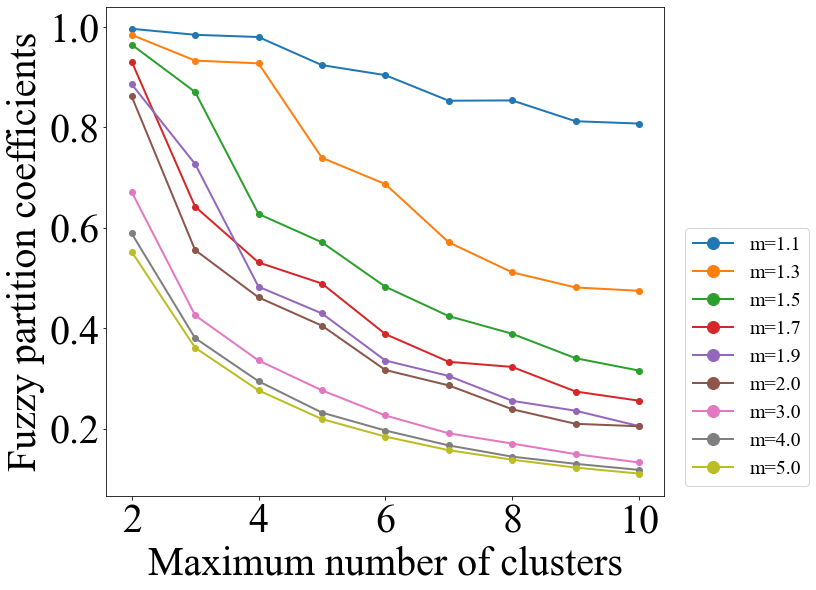

In [8]:
fig = plt.figure(figsize=(10, 9))

ax1 = fig.add_subplot(1, 1, 1, ylabel='Fuzzy partition coefficients', xlabel='Maximum number of clusters')
ax1.set_xlabel('Maximum number of clusters', fontsize=fontsize1, fontname='Times New Roman')
ax1.set_ylabel('Fuzzy partition coefficients', fontsize=fontsize1, fontname='Times New Roman')
ax1.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax1.set_xticks([2, 4, 6, 8, 10])

for i in range(mn):
    curfpc = fpcs[:, i]
    xcurfpc = np.array([j+2 for j in range(0, max_nk-1)])
    ax1.plot(xcurfpc, curfpc, marker="o",linewidth=2, label="m="+str(ms[i]))
    
ax1.legend(bbox_to_anchor=(1.02, 0.0), loc='lower left',fontsize=20,markerscale=2)
plt.show()

fig.savefig(f'fcmeans/plots/NkVsFPC.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/NkVsFPC.png', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/NkVsFPC.svg', dpi=300, bbox_inches='tight')

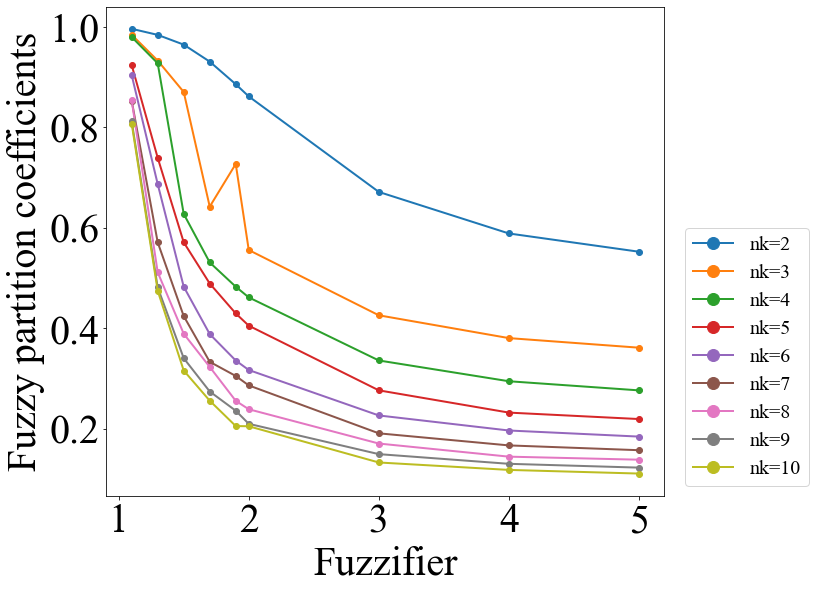

In [9]:
fig = plt.figure(figsize=(10, 9))

ax2 = fig.add_subplot(1, 1, 1, ylabel='Fuzzy partition coefficients', xlabel='Fuzzifier')
ax2.set_xlabel('Fuzzifier', fontsize=fontsize1, fontname='Times New Roman')
ax2.set_ylabel('Fuzzy partition coefficients', fontsize=fontsize1, fontname='Times New Roman')
ax2.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax2.set_xticks([1, 2, 3, 4, 5])
    
for i in range(max_nk-1):
    curfpc = fpcs[i]
    xcurfpc = ms
    ax2.plot(xcurfpc, curfpc, marker="o",linewidth=2, label="nk="+str(i+2))

ax2.legend(bbox_to_anchor=(1.02, 0.0), loc='lower left',fontsize=20,markerscale=2)
plt.show()

fig.savefig(f'fcmeans/plots/FuzVsFPC.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/FuzVsFPC.png', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/FuzVsFPC.svg', dpi=300, bbox_inches='tight')

## Part 2: Fuzzifier dependence with n = 3

In [10]:
nk = 3
ms = np.array([1.1, 1.3, 1.5, 1.8, 2])

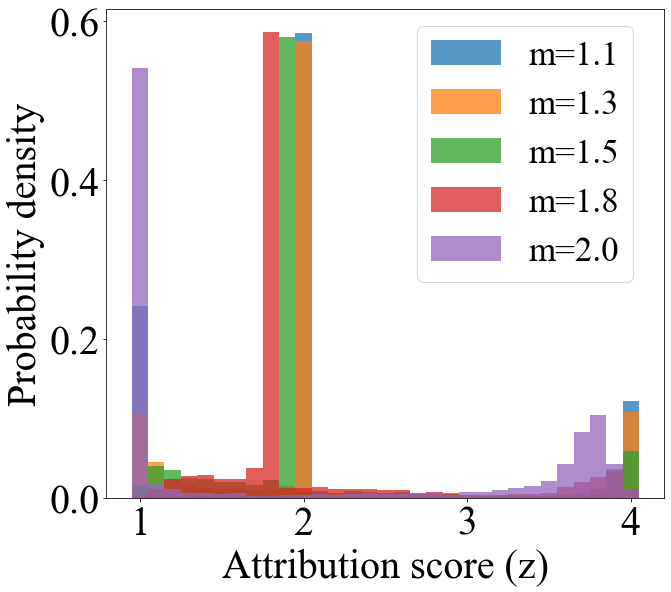

Elapsed Time:  21.989990234375


In [11]:
mn = np.size(ms)

t1 = time.time() 
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Attribution score (z)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Probability density', fontsize=fontsize1, fontname='Times New Roman')
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 

for ii in range(mn):
    m = ms[ii]
    cntr, u, u0, d, jm, p, fpc = cmeans(targetMap.T, nk, m, 0.003, 10000, seed = 10)

    z = np.zeros(pn)
    for i in range(pn):
        for j in range(nk):
            z[i] += u[j][i] * 2 ** (j)

    zmin = 1
    zmax = np.amax(z).round()

    dbin = 0.1
    bn = int((zmax-zmin)/dbin)+1

    z_hist, z_bins = np.histogram(z, bins=bn)
    z_hist = z_hist / np.sum(z_hist)
    z_xhist = []
    for i in range(bn):
        z_xhist.append(zmin+i*dbin)

    ax.bar(z_xhist, z_hist, align='center', width=dbin, alpha=0.75, label = 'm='+str(m))
    
ax.legend(bbox_to_anchor=(0.525, 1.0), loc='upper left',prop={'size': fontsize2, 'family': 'Times New Roman'})
plt.show()

fig.savefig(f'fcmeans/plots/Zdistribution_{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/Zdistribution_{nk}.png', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/Zdistribution_{nk}.svg', dpi=300, bbox_inches='tight')

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)


## Part 3: Perform Fuzzy-c-means clustering with n = 3 and m = 1.1, 1.3, 1.5, 1.8, 2.0

In [12]:
nk = 3
m = 1.1

### - Clustering

In [13]:
t1 = time.time() 
cntr, u, u0, d, jm, p, fpc = cmeans(targetMap.T, nk, m, 0.003, 10000, seed = 10)  
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

Elapsed Time:  3.72212290763855


### - Probability Density

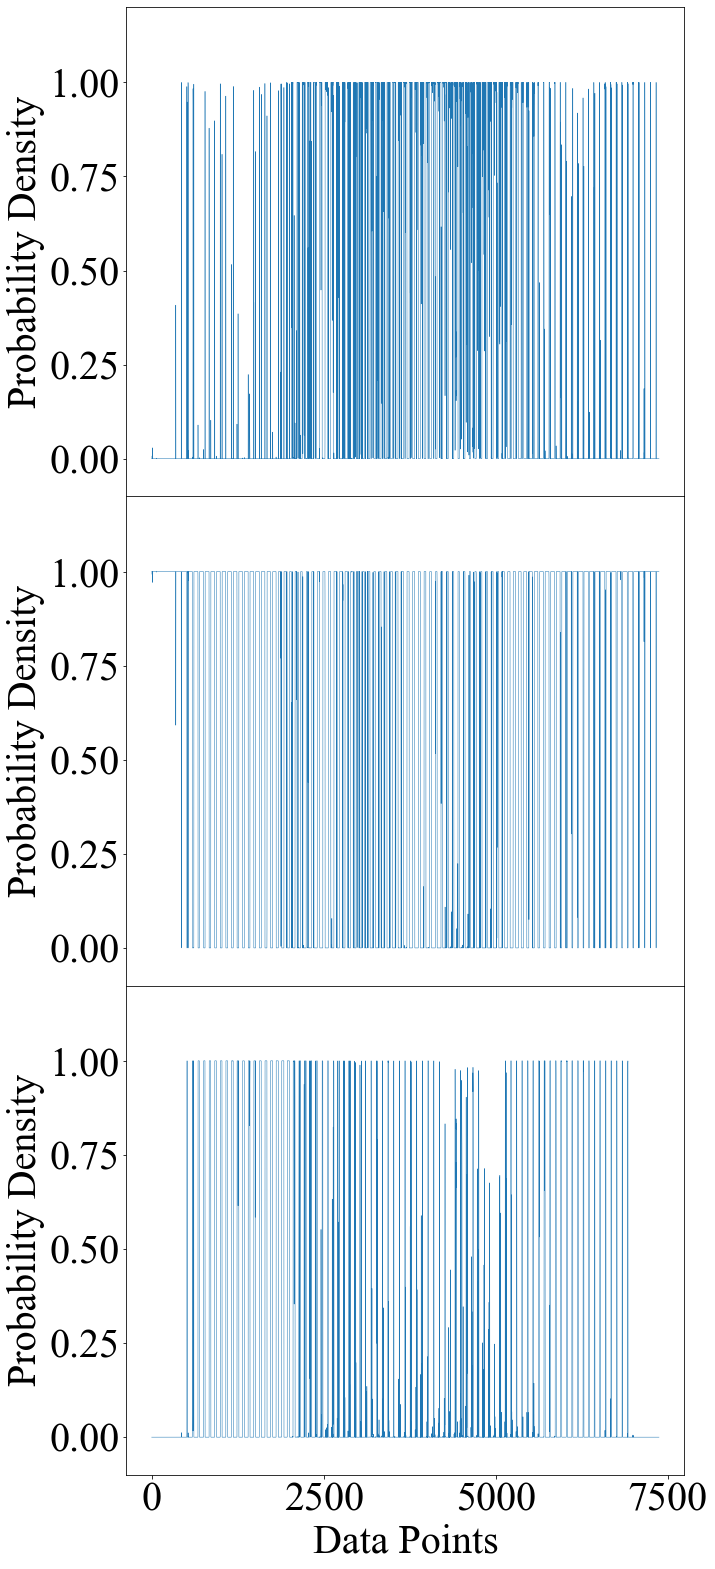

Elapsed Time:  2.2507896423339844


In [14]:
t1 = time.time() 

fig = plt.figure(figsize=(10, 9*nk))
gs = fig.add_gridspec(nk, 1, hspace=0)

for i in range(nk):
    curprob = u[i]
    curax = fig.add_subplot(gs[i, 0])
    curax.plot(curprob, linewidth=0.5)
    curax.tick_params(axis='y', which='major', labelsize=fontsize1)
    curax.set_ylim(-0.1, 1.2)
    curax.set_ylabel('Probability Density', fontsize=fontsize1, fontname='Times New Roman')
    if i == nk-1:
        curax.set_xlabel('Data Points', fontsize=fontsize1, fontname='Times New Roman')
        curax.tick_params(axis='x', which='major', labelsize=fontsize1)  


fig.savefig(f'fcmeans/plots/probability_density_{nk}_{m}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/probability_density_{nk}_{m}.png', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/probability_density_{nk}_{m}.svg', dpi=300, bbox_inches='tight')
plt.show()    

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

### - Spatial Distribution of clusters (Z score)

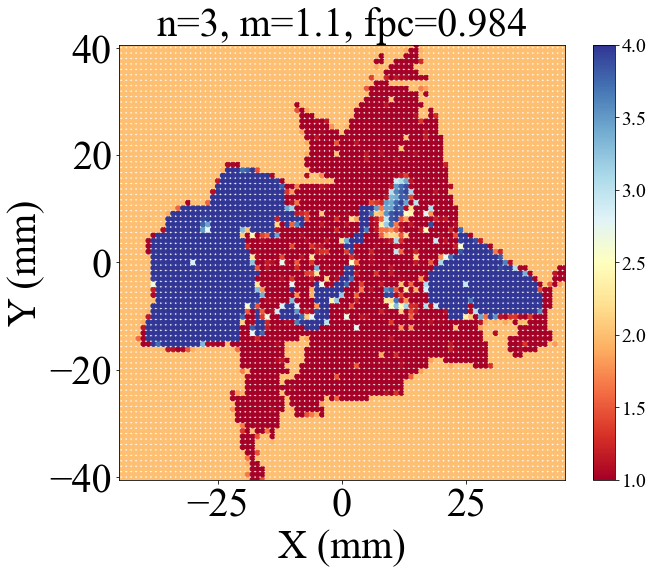

Elapsed Time:  2.4763972759246826


In [15]:
t1 = time.time() 

z = np.zeros(pn)
for i in range(pn):
    for j in range(nk):
        z[i] += u[j][i] * 2 ** (j)  

zmin = 1
zmax = np.amax(z).round()
z2d = z.reshape(xn, yn) # For output as 2D image

fig = plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('RdYlBu')
ax = fig.add_subplot(1, 1, 1, xlabel='X (mm)', ylabel='Y (mm)')
ax.set_xlim(-xw/2, xw/2)  
ax.set_ylim(-yw/2, yw/2)  
ax.tick_params(axis='y', which='major', labelsize=fontsize1) 
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')
mappable = ax.scatter(xpos, ypos, c=z, vmin=zmin, vmax=zmax, marker=markershape, s=markersize, cmap=cm)        
color_bar = fig.colorbar(mappable)
color_bar.ax.tick_params(labelsize=20)
plt.title('n='+str(nk)+', m='+str(m)+', fpc='+str(format(fpc,'.3f')), fontsize=fontsize1, fontname='Times New Roman') 
plt.show()

fig.savefig(f'fcmeans/plots/clustering_result_{nk}_{m}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/clustering_result_{nk}_{m}.png', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/clustering_result_{nk}_{m}.svg', dpi=300, bbox_inches='tight')


t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

## Part 4: Fuzzifier dependence with n = 5

In [16]:
nk = 5
ms = np.array([1.1, 1.3, 1.5, 1.8,2])

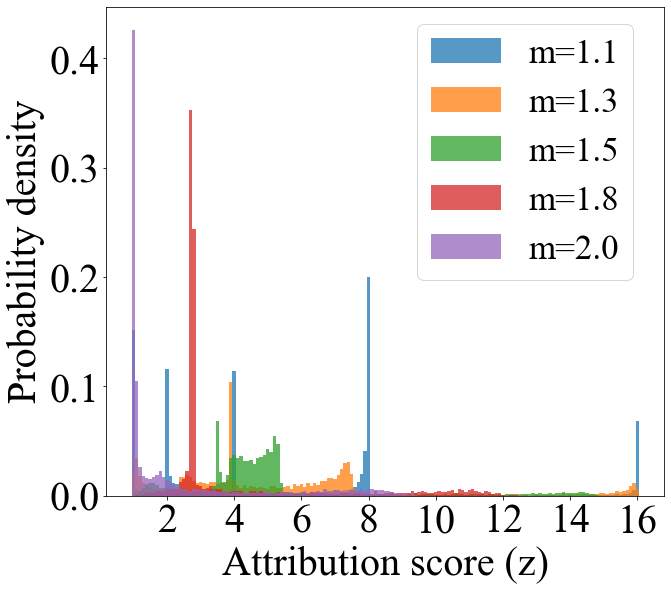

Elapsed Time:  20.788084506988525


In [17]:
mn = np.size(ms)

t1 = time.time() 
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Attribution score (z)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Probability density', fontsize=fontsize1, fontname='Times New Roman')
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_xticks([2, 4, 6, 8, 10, 12, 14, 16,18])

for ii in range(mn):
    m = ms[ii]
    cntr, u, u0, d, jm, p, fpc = cmeans(targetMap.T, nk, m, 0.003, 10000, seed = 10)

    z = np.zeros(pn)
    for i in range(pn):
        for j in range(nk):
            z[i] += u[j][i] * 2 ** (j)

    zmin = 1
    zmax = np.amax(z).round()

    dbin = 0.1
    bn = int((zmax-zmin)/dbin)+1

    z_hist, z_bins = np.histogram(z, bins=bn)
    z_hist = z_hist / np.sum(z_hist)
    z_xhist = []
    for i in range(bn):
        z_xhist.append(zmin+i*dbin)

    ax.bar(z_xhist, z_hist, align='center', width=dbin, alpha=0.75, label = 'm='+str(m))
    
ax.legend(bbox_to_anchor=(0.525, 1.0), loc='upper left',prop={'size': fontsize2, 'family': 'Times New Roman'})
plt.show()

fig.savefig(f'fcmeans/plots/Zdistribution_{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/Zdistribution_{nk}.png', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/Zdistribution_{nk}.svg', dpi=300, bbox_inches='tight')

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

## Part 5: Perform Fuzzy-c-means clustering with n = 5 and m = 1.1, 1.3, 1.5, 1.8, 2.0

In [18]:
nk = 5
m = 1.1

### - Clustering

In [19]:
t1 = time.time() 
cntr, u, u0, d, jm, p, fpc = cmeans(targetMap.T, nk, m, 0.003, 10000, seed = 10)  
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

Elapsed Time:  5.388615131378174


### - Probability Density

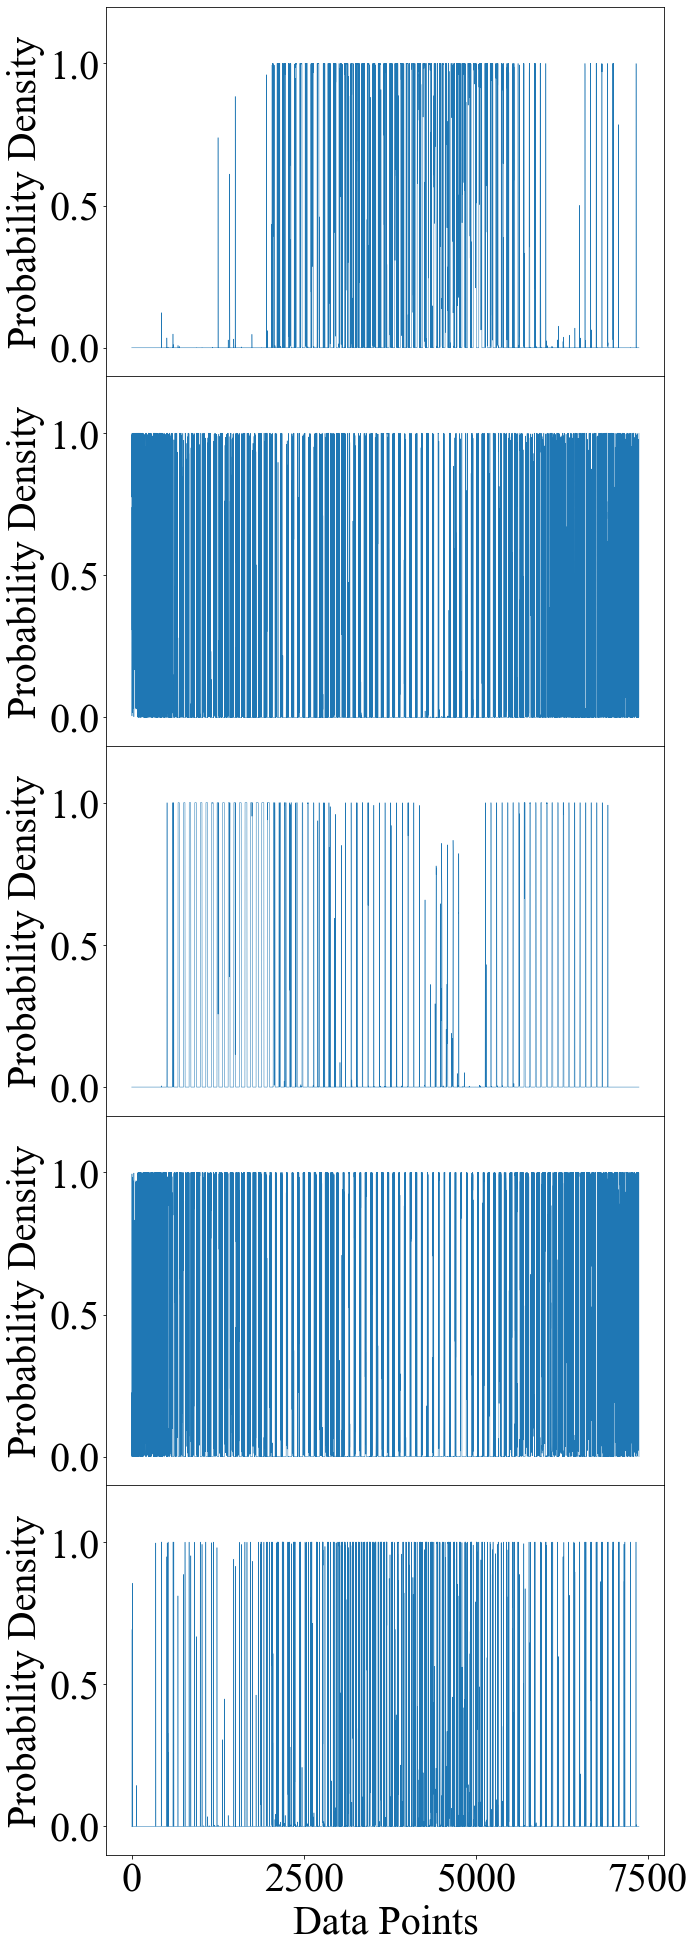

Elapsed Time:  3.7617554664611816


In [20]:
t1 = time.time() 

fig = plt.figure(figsize=(10, 6.8*nk))
gs = fig.add_gridspec(nk, 1, hspace=0)

for i in range(nk):
    curprob = u[i]
    curax = fig.add_subplot(gs[i, 0])
    curax.plot(curprob, linewidth=0.5)
    #curax.plot(curprob, marker='o', color='b')
    #curax.scatter(range(len(curprob)), curprob, color='b', s=0.5)
    curax.tick_params(axis='y', which='major', labelsize=fontsize1)
    curax.set_ylim(-0.1, 1.2)
    curax.set_ylabel('Probability Density', fontsize=fontsize1, fontname='Times New Roman')
    if i == nk-1:
        curax.set_xlabel('Data Points', fontsize=fontsize1, fontname='Times New Roman')
        curax.tick_params(axis='x', which='major', labelsize=fontsize1)  
plt.show()

fig.savefig(f'fcmeans/plots/probability_density_{nk}_{m}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/probability_density_{nk}_{m}.png', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/probability_density_{nk}_{m}.svg', dpi=300, bbox_inches='tight')

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

### - Spatial Distribution of clusters (Z score)

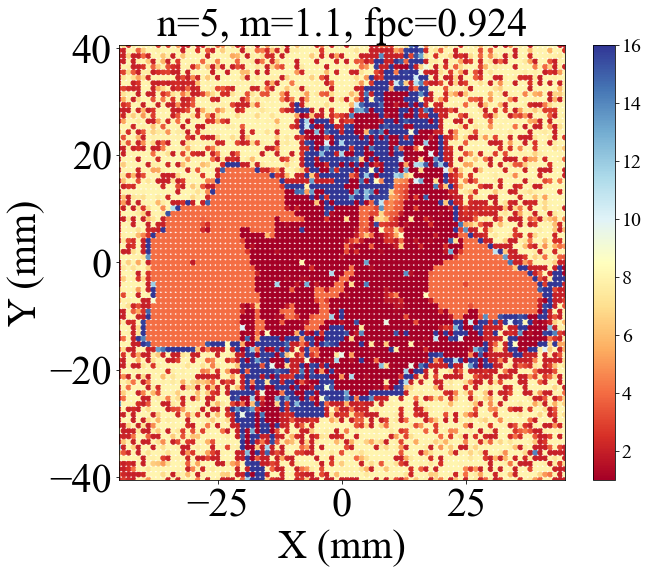

Elapsed Time:  2.8183436393737793


In [21]:
t1 = time.time() 

z = np.zeros(pn)
for i in range(pn):
    for j in range(nk):
        z[i] += u[j][i] * 2 ** (j)  

zmin = 1
zmax = np.amax(z).round()
z2d = z.reshape(xn, yn) # For output as 2D image

fig = plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('RdYlBu')
ax = fig.add_subplot(1, 1, 1, xlabel='X (mm)', ylabel='Y (mm)')
ax.set_xlim(-xw/2, xw/2)  
ax.set_ylim(-yw/2, yw/2)  
ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')
mappable = ax.scatter(xpos, ypos, c=z, vmin=zmin, vmax=zmax, marker=markershape, s=markersize, cmap=cm)        
color_bar = fig.colorbar(mappable)
color_bar.ax.tick_params(labelsize=20)
plt.title('n='+str(nk)+', m='+str(m)+', fpc='+str(format(fpc,'.3f')), fontsize=fontsize1, fontname='Times New Roman') 
plt.show()

fig.savefig(f'fcmeans/plots/clustering_result_{nk}_{m}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/clustering_result_{nk}_{m}.png', dpi=300, bbox_inches='tight')
fig.savefig(f'fcmeans/plots/clustering_result_{nk}_{m}.svg', dpi=300, bbox_inches='tight')


t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)